In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans
from scipy import cluster

# Assignment 2 (due Oct 3rd at 11:59pm)

- This assignment covers PCA and clustering methods. Please refer to the class notes and corresponding Colabs on the course website for the required background.

- This assignment is worth **100 points**.  After completing the solutions you will submit a copy of this notebook (`.ipynb`), including all your answers.

- You are free to use any of the tensor libraries (`numpy`, `pytorch`, or `tensorflow`).  For PCA and clustering, you can use your own implementation or `scikit-learn` functions/classes.

>  **Important**: Make sure all cells are executed before saving/downloading a copy of the notebook you will submit.

## Question 1
Here we download the [Olivetti Faces](https://www.openml.org/search?type=data&status=active&id=41083) dataset from OpenML.  **Carefully read the description** of this dataset following the link provided.  You should understand the dataset and all of its features.

- the images are saved into the `X` array and their corresponding labels into `y`
- we will focus on *unsupersised learning* methods, the labels `y` won't be necessary
- `fetch_openml` downloads the data from the internet, it is suggested that you run this cell only once (per session)
- every row in `X` is an array of 4096 pixel values, that corresponds to an image of 64 x 64 pixel values
- every pixel value is a grayscale intensity ranging from 0 to 1

In [2]:
# download the dataset
X, y = fetch_openml(data_id=41083, return_X_y=True, as_frame=False)
print(X.shape, y.shape)
# inspect ranges
print(np.min(X), np.max(X))

(400, 4096) (400,)
0.0 1.0


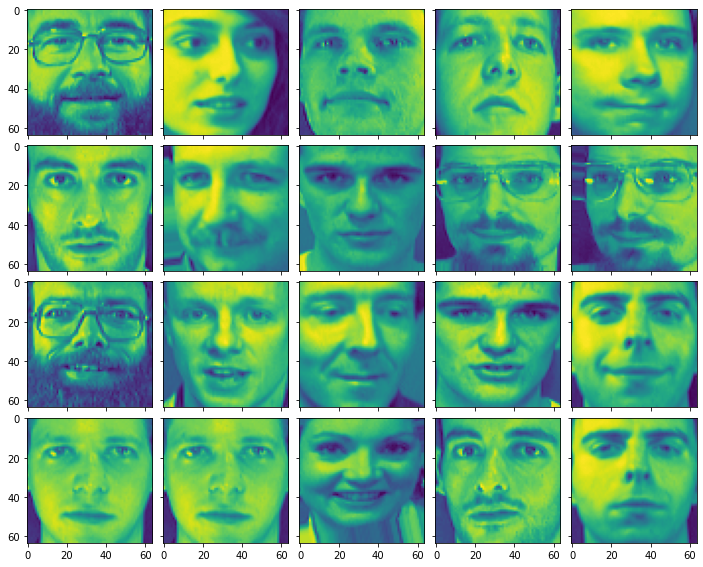

In [3]:
# plot 20 random images
idxs = np.arange(X.shape[0])
grid = ImageGrid(plt.figure(figsize=(12,15)), 111, nrows_ncols=(4,5), axes_pad=0.15)
for ax in grid:
    ax.imshow(X[np.random.choice(idxs)].reshape(64,64), cmap='viridis')
# images are grayscale, however they appear colored because 
# of the colormap used to map scalar pixel values to colors (imshow)

## Question 2
Write a function that performs PCA on an input tensor `X` of shape `n x d`, with `n` being the number of images and `d` the number of pixel values.  The function should return a matrix `E` with shape `d X d` with the eigenvectors as columns, and an array `v` with the eigenvalues.  Eigenvalues (and corresponding eigenvectors) should be sorted in decreasing order.

> You can use the code provided in class, or any other library.

In [4]:
# your answer here

# Function is based on Google Colab notebook by Dr. Marco Alvarez at the University of Rhode Island
def pca(X):
    # Center data
    X = X - np.mean(X, axis=0)
    # Calculate covariance matrix
    cov_X = (X.T @ X) / (X.shape[0])
    # Calcluate Eigenvalues and Eigenvectors
    evals, evecs = np.linalg.eigh(cov_X)
    # Find sorted indices of eigenvalues in decreasing order
    dec_indexes = np.argsort(evals)[::-1]
    # Now sort the eigenvalues and related eigenvectors
    v = evals[dec_indexes]
    E = evecs[:, dec_indexes]
    # Return evecs (E) and evals (v)
    return E, v



## Question 3 (30 pts)
Call the function from Question 2 once.  Save the returned values into `eigvecs` and `eigvals`.  Then, create an ImageGrid of shape `5x2`, showing the top 10 eigenvectors.  Each eigenvector contains `d` values that can be reshaped into a matrix of $\sqrt d\times \sqrt d$ values.  Eigenvectors on face datasets are also known as [eigenfaces](https://en.wikipedia.org/wiki/Eigenface).  Describe what you find in the resulting figure.


In [6]:
# your answer here
evecs, evals = pca(X) # Create eigenvectors and eigenvalues by calling the pca function above

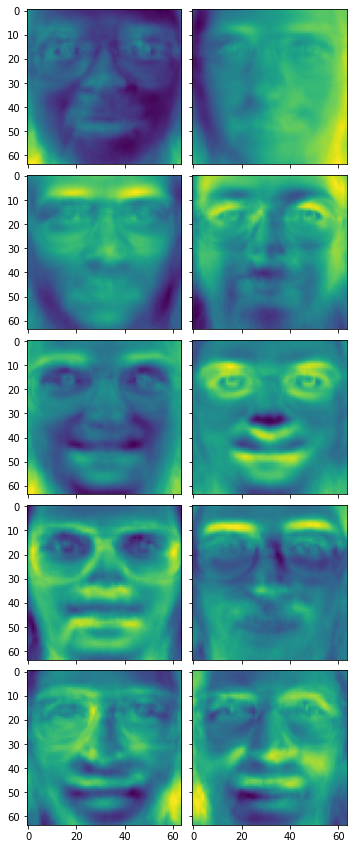

In [7]:
eigfaces = ImageGrid(plt.figure(figsize=(12,15)), 111, nrows_ncols=(5,2), axes_pad=0.15) # Create image grid of eigenfaces
i = 0 # Initialize i to be able to get each eigenface from image grid
for ax in eigfaces: 
    ax.imshow(evecs[:, i].reshape(64,64), cmap="viridis") # Show eigenface after reshaping eigenvector to become a 64x64 image 
    i = i+1

The eigenfaces look like the images but with less definition. This is because these are the principal components in the images.  

## Question 4 (10 pts)
Create a plot showing the values of the top-100 eigenvalues in decreasing order.  Describe what you find in the plot.

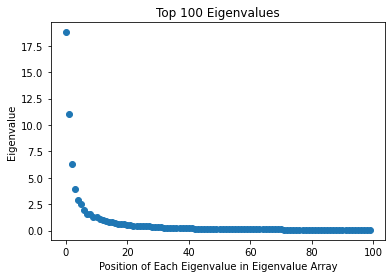

In [47]:
# your answer here
plt.title("Top 100 Eigenvalues")
plt.xlabel("Position of Each Eigenvalue in Eigenvalue Array")
plt.ylabel("Eigenvalue")
plt.scatter(range(100), evals[:100])

This plot has the shape that we would expect to see since our most important eigenvalues are at the beginning and have the biggest spread from other data points. The eigenvalues converge to 0 as it approaches 100 which is expected. The most important eigen values are the top 3 since they have the biggest spread. The top 2 will be used to transform the data and project it into 2-d space.

## Question 5 (10 pts)
Create a plot showing the explained variance (cumulative variance) for the top-100 principal components.  
> Make sure eigenvalues are sorted in decreasing order

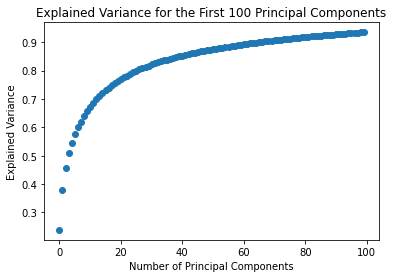

In [46]:
# your answer here
sum_of_eigenvalues = sum(evals) # Sum all the eigenvalues to be used to calculate variance of each eigenvalue
variance_of_evals = evals[:100] / sum_of_eigenvalues # Calculate the variance of each eigenvalue
explained_variance = np.cumsum(variance_of_evals) # Calculate the explained variance 

plt.title("Explained Variance for the First 100 Principal Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Explained Variance")
plt.scatter(range(100), explained_variance)

## Question 6 (30 pts)
We know there are 40 different subjects (persons) in the dataset.  Here you will use `k-means` with `k=40` to find a good clustering using a *projected dataset*, i.e., a dataset with reduced dimensions.  The key point is to figure out how many PCs (principal components) to use in the projected dataset.  Your goal will be to generate a plot of SSE (sum of squared distances to centroids) as a function of the number of PCs.  The different numbers of PCs to try should be `np.array(2 ** np.linspace(1, 8, 12), dtype=int)`.  Describe what you find in the plot.

In [10]:
num_of_pcs_to_try = np.array(2 ** np.linspace(1, 8, 12), dtype=int) # Get array of principal components to test
num_of_pcs_to_try

array([  2,   3,   4,   7,  11,  18,  28,  43,  68, 105, 164, 256])

In [11]:
algo = KMeans(n_clusters = 40, init='random', n_init = 20) # Create K-Means algo. with num of initializations equal to half the number of images in the dataset

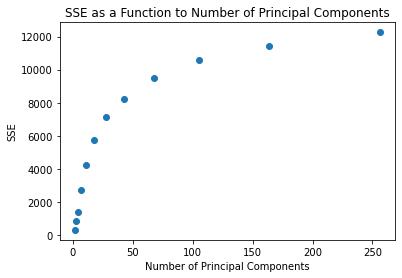

In [45]:
sse_array = [] # Initialize array to hold sum of squared error (SSE) of each model 
for pc in num_of_pcs_to_try: # Loop through number of principal components to try
    X_projected = X @ evecs[:, :pc] # Create a projected dataset based on the array of principal components to try
    clustered = algo.fit(X_projected) # Fit K-Means on the projected dataset
    sse = clustered.inertia_ # Record the SSE of K-Means on the dataset
    sse_array.append(sse) # Append this value to the array holding sse

plt.title("SSE as a Function to Number of Principal Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("SSE")
plt.scatter(num_of_pcs_to_try, sse_array) # Plot SSE as a function of Number of Principal Components to try
     

The output of SSE to Principal Components (PCs) is what is expected for testing more and more PCs. It creates an elbow shape and we can determine that the ideal amount of PCs to use would be 7 PCs since this is the elbow of the plot. 

## Question 7 (20 pts)
Use hierarchical agglomerative clustering ('ward') to generate and plot two dendrograms.  One for the original data, and the second for the projected data, using the best number of PCs (from the plot in question 6).
> hint: use `scipy.cluster.hierarchy`

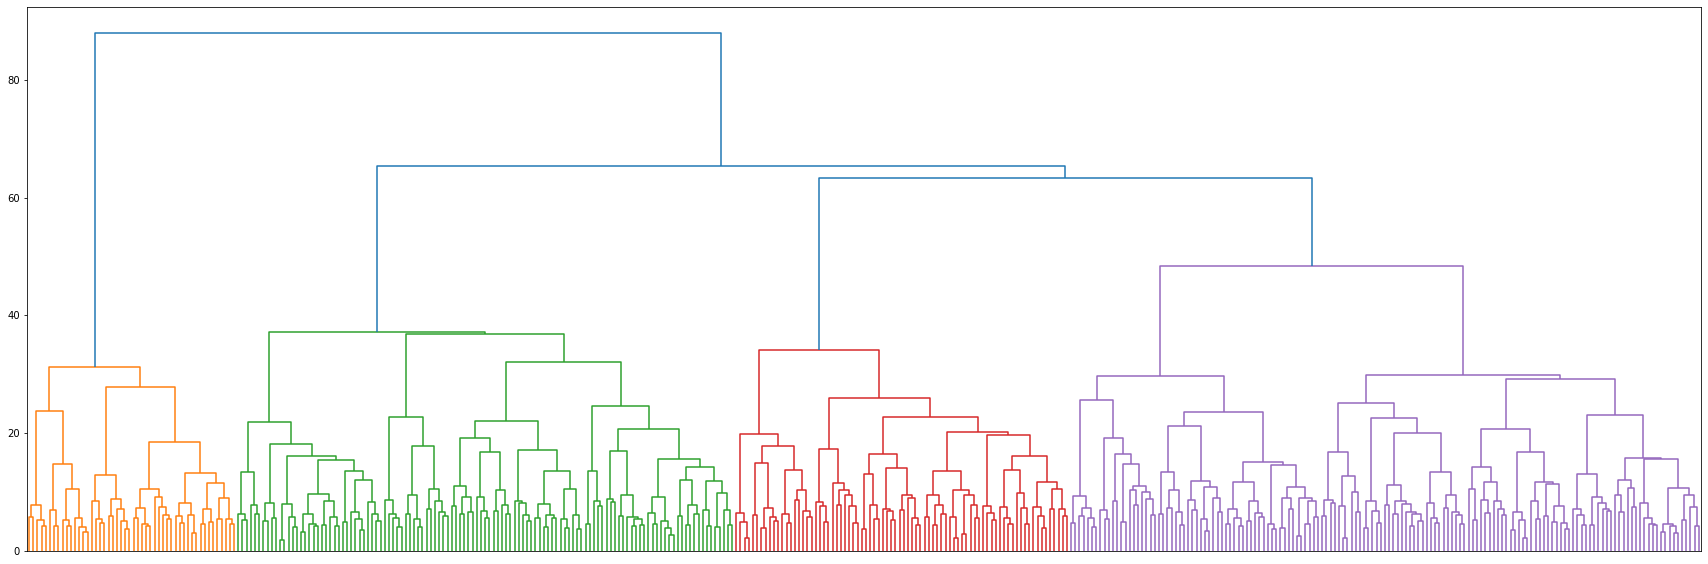

In [44]:
# your answer here
plt.figure(figsize=(30,10))
original_ds_ward = cluster.hierarchy.ward(X) # Perform agglomerative clustering on the original dataset
cluster.hierarchy.dendrogram(original_ds_ward, no_labels = True, count_sort=True) # Create a dendrogram to display the heirarchy of the clustering
plt.show()

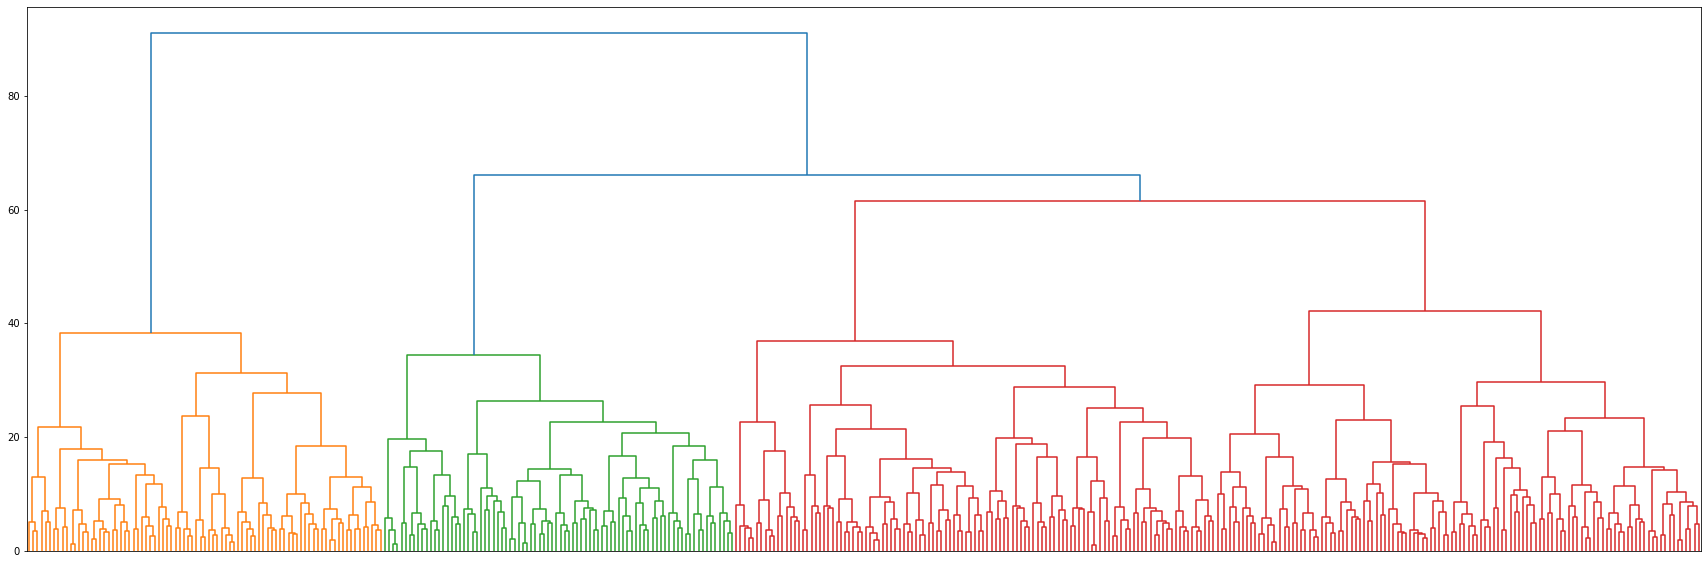

In [42]:
plt.figure(figsize=(30,10))
X_projected_best_pc = X @ evecs[:, :num_of_pcs_to_try[9]] # Create Projected Data based on best number of PCs
X_best_pc_ward = cluster.hierarchy.ward(X_projected_best_pc) # Use agglomerative clustering on the projected dataset
cluster.hierarchy.dendrogram(X_best_pc_ward, no_labels=True, count_sort=True) # Create a Dendrogram to show the heirarchy of the clustering
plt.show()